# Workshop on scene mapping and localization from sensor data

Course: Spatial Reasoning from Sensor Data, https://www.iss.nus.edu.sg/executive-education/course/detail/spatial-reasoning-from-sensor--data/artificial-intelligence

Contact: Tian Jing

Email: tianjing@nus.edu.sg

## Objective

- The objective of this workshop is to perform place recognition and localization

## Reference

- Dataset: Scene recognition, https://www.cc.gatech.edu/~hays/compvision/proj4/. The place dataset is downloaded at https://www.cc.gatech.edu/~hays/compvision/proj4/data.zip
    
- This workshop code is modified from the original Caffe version in the following reference to be Keras version. 

- Refrence: 'Benchmark for Image Retrieval (BKIR)', https://github.com/willard-yuan/cnn-cbir-benchmark

## Submission guideline

Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.


In [ ]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models.vgg as vgg

print("PyTorch version is", torch.__version__)

# Use GPU if available else revert to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)


PyTorch version is 1.8.1+cu101
Device being used: cpu


In [ ]:
# Then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit enter

from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder, please keep ''/content/gdrive/My Drive/XXX' in the path and change XXX to be your own folder.
# The path is case sensitive.
import os
os.chdir('/content/gdrive/My Drive/SRSD/localization')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
archive
data
wk_place_recognition_keras_v202107_reference.ipynb
wk_place_recognition_pytorch_v202107.ipynb
wk_pt_place_recognition_v4.1_with_solution.ipynb


## Prepare training images set and test images set

In [ ]:
# Prepare the training folder and image file list
train_image_folder_name = 'data/scene/train'
train_image_file_list = []
train_image_class_list = os.listdir(train_image_folder_name)
for subfolder in train_image_class_list:
    file_list = os.listdir(train_image_folder_name + '/' + subfolder)
    for file in file_list:
        train_image_file_list.append(train_image_folder_name + '/' + subfolder + '/' + file)

print("Training: %d classes, %d images" % (len(train_image_class_list), len(train_image_file_list)))

# Prepare the test folder and image file list
test_image_folder_name = 'data/scene/test'
test_image_file_list = []
test_image_class_list = os.listdir(test_image_folder_name)
for subfolder in test_image_class_list:
    file_list = os.listdir(test_image_folder_name + '/' + subfolder)
    for file in file_list:
        test_image_file_list.append(test_image_folder_name + '/' + subfolder + '/' + file)

print("Test: %d classes, %d images" % (len(test_image_class_list), len(test_image_file_list)))


Training: 15 classes, 1500 images
Test: 15 classes, 2985 images


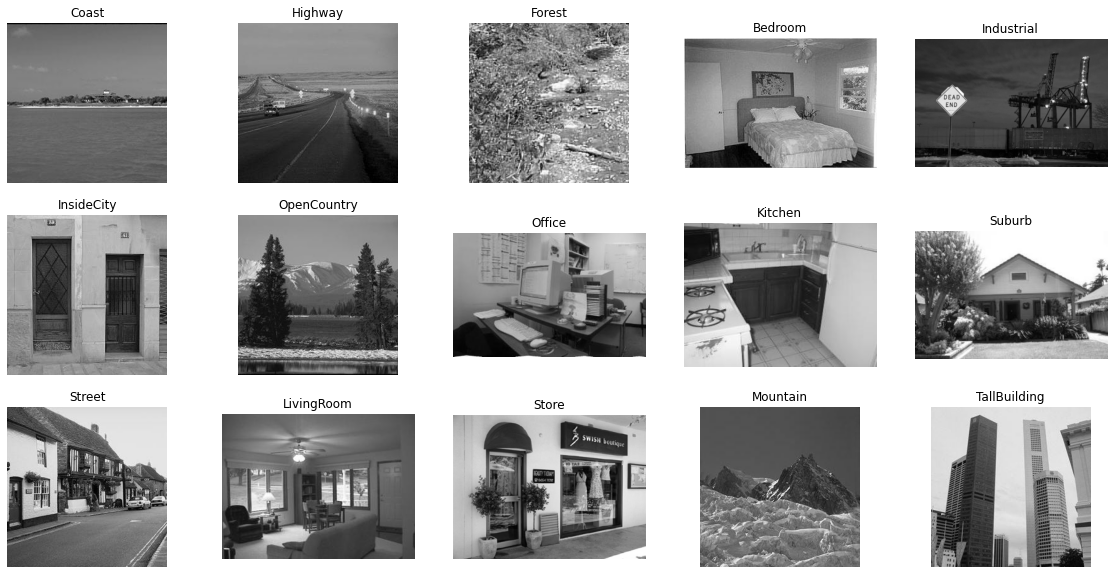

In [ ]:
# Illustrate sample training images
train_image_folder_name = 'data/scene/train'
plt.figure(figsize=(20,10))
i = 0
for subfolder in train_image_class_list:
    file_list = os.listdir(train_image_folder_name + '/' + subfolder)
    for file in file_list:
        if '.jpg' in file:
            i = i+1
            plt.subplot(3, 5, i)
            plt.imshow(cv2.imread(train_image_folder_name + '/' + subfolder + '/' + file))
            plt.axis("off")
            plt.title(subfolder)
            break
plt.show()    


In [ ]:
# Compare the input query file name and the result file name lists to calculate the precision performance
# For example
# input_file_name: data/scene/train/Mountain/image_0076.jpg
# result_file_name_list: a list of top_return files in query results
# Precision: Number of true returned results/Total number of results
# Accuracy: 1: IF there is at least one true returned result; 0: All returned results are wrong
def cal_precision(input_file_name, result_file_name_list):
    num = 0
    input_class = input_file_name.split("/")[3]
    for result_file_name in result_file_name_list:
        result_class = result_file_name.split("/")[3]
        if (input_class == result_class):
            num = num+1
    return (num/len(result_file_name_list))

def cal_accuracy(input_file_name, result_file_name_list):
    result = 0
    input_class = input_file_name.split("/")[3]
    for result_file_name in result_file_name_list:
        result_class = result_file_name.split("/")[3]
        if (input_class == result_class):
            result = 1
            break
    return (result)

def cal_vec_dist(vec1, vec2):
    '''
    Description: calculate the Euclidean Distance of two vectors
    '''
    return np.linalg.norm(vec1 - vec2)


## VLAD: Step 0, Define functions

- Reference: Hervé Jegou, Florent Perronnin, Matthijs Douze, Jorge Sanchez, Patrick Perez, "Aggregating local image descriptors into compact codes," IEEE Trans. on Pattern Analysis and Machine Intelligence, Vol. 34, No. 9, 2012, pp.1704-1716. https://hal.inria.fr/inria-00633013/document/



In [ ]:
# Configuration
vlad_CODEBOOKDIM = 100 # number of clusters
sift_DESDIM = 128 # dimension of feature

# Various functions used in VLAD
def sift_extractor(file_path):
    '''
    Description: extract SIFT feature from given image
    Input: file_path - image
    Output: des - a list of descriptors of all the keypoint from the image
    '''
    img = cv2.imread(file_path)
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=500) # number of feature points
    _,des = sift.detectAndCompute(gray, None) 

    return des


def get_cluster_center(des_set, K):
    '''
    Description: cluter using a default setting
    Input: des_set - cluster data
           K - the number of cluster center
    Output: label  - a np array of the nearest center for each cluster data
            center - a np array of the K cluster center
    '''
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.01)
    des_set = np.float32(des_set)
    ret, label, center = cv2.kmeans(des_set, K, None, criteria, 3, cv2.KMEANS_RANDOM_CENTERS)
    return label, center


def get_des_vector(file_path_list):
    '''
    Description: get descriptors of all the images 
    Input: file_path_list - all images path
    Output:       all_des - a np array of all descriptors
            iamge_des_len - a list of number of the keypoints for each image 
    '''
    all_des = np.empty(shape=[0, sift_DESDIM]) # Define all description vector according to dimension of SIFT feature
    image_des_len = []

    #for eachFile in file_path_list:
    for idx, eachFile in enumerate(file_path_list):
        try:
            des = sift_extractor(eachFile)
            all_des = np.concatenate([all_des, des])
            image_des_len.append(len(des))
            if ((idx % 100) == 0):
                print("get_des_vector %d/%d file: %s" % (idx+1, len(file_path_list), eachFile))
        except:
            print(eachFile)
            #image_des_len.append(0)
            print("extract feature error")
    return all_des, image_des_len


def get_codebook(all_des, K):
    '''
    Description: train the codebook from all of the descriptors
    Input: all_des - training data for the codebook
           K - the column of the codebook

    '''
    label, center = get_cluster_center(all_des, K)
    return label, center


def get_vlad_base(img_des_len, NNlabel, all_des, codebook):
    '''
    Description: get all images vlad vector 
    '''
    cursor = 0
    vlad_base = []
    for eachImage in img_des_len:
        descrips = all_des[cursor : cursor + eachImage]
        centriods_id = NNlabel[cursor : cursor + eachImage]
        centriods = codebook[centriods_id]
    
        vlad = np.zeros(shape=[vlad_CODEBOOKDIM, sift_DESDIM])
        for eachDes in range(eachImage):
            vlad[centriods_id[eachDes]] = vlad[centriods_id[eachDes]] + descrips[eachDes] - centriods[eachDes]
        cursor += eachImage
    
        vlad_norm = vlad.copy()
        cv2.normalize(vlad, vlad_norm, 1.0, 0.0, cv2.NORM_L2)
        vlad_base.append(vlad_norm.reshape(vlad_CODEBOOKDIM * sift_DESDIM, -1))

    return vlad_base


def get_pic_vlad(pic, des_size, codebook):
    '''
    Description: get the vlad vector of each image
    '''
    vlad = np.zeros(shape=[vlad_CODEBOOKDIM, sift_DESDIM])
    for eachDes in range(des_size):
        des = pic[eachDes]
        min_dist = 1000000000.0
        ind = 0
        for i in range(vlad_CODEBOOKDIM):
            dist = cal_vec_dist(des, codebook[i])
            if dist < min_dist:
                min_dist = dist
                ind = i
        vlad[ind] = vlad[ind] + des - codebook[ind]
    
    vlad_norm = vlad.copy()
    cv2.normalize(vlad, vlad_norm, 1.0, 0.0, cv2.NORM_L2)
    vlad_norm = vlad_norm.reshape(vlad_CODEBOOKDIM * sift_DESDIM, -1)
    
    return vlad_norm


## VLAD: Step 1, Extract features from both training and test data set

In [ ]:
# # Uncomment followings to re-calculate all features
# # Get all the descriptor vectors of the whole training data set
# print('Extract SIFT features from training images')
# all_des, train_image_des_len = get_des_vector(train_image_file_list)

# # trainning the codebook
# print('Build the VLAD code book from the training images')
# NNlabel, vlad_codebook = get_codebook(all_des, vlad_CODEBOOKDIM)

# print('VLAD codebook is built')
# print("Dimension of vlad_codebook is (vlad_CODEBOOKDIM, sift_DESDIM) = ", vlad_codebook.shape)
# np.save('data/vlad_codebook.npy', vlad_codebook)

# # Extract features from training images
# print('Extract features from train images')
# vlad_train = get_vlad_base(train_image_des_len, NNlabel, all_des, vlad_codebook)
# print("Length of vlad_train: %d, as same as number of training images %d" % (len(vlad_train), len(train_image_file_list)))
# np.save('data/train_all_feature_vlad.npy', vlad_train)

# print('Extract features from test images')

# # get all the descriptor vectors of the whole test data set
# number_test_images = 100 # len(test_image_file_list) # use a subset not the full set of 2985 test images
# ret_file_path_list = random.sample(test_image_file_list, number_test_images)

# # Extract featkures from test images
# ret_des, ret_des_len = get_des_vector(ret_file_path_list)

# # get all the vlad vectors of test set
# cursor_ret = 0
# vlad_test = []
# for eachretpic in range(len(ret_des_len)):
#     pic = ret_des[cursor_ret: cursor_ret + ret_des_len[eachretpic]]
#     ret_vlad = get_pic_vlad(pic, ret_des_len[eachretpic], vlad_codebook)
#     cursor_ret += ret_des_len[eachretpic]
#     vlad_test.append(ret_vlad)

# print('Extract features from test images is done')
# np.save('data/test_all_feature_vlad.npy', vlad_test) # The list of VLAD feature of each test file
# np.save('data/ret_file_path_list_vlad.npy', ret_file_path_list)

In [ ]:
# Use the pre-calculated features provided in the workshop
vlad_codebook = np.load('data/vlad_codebook.npy')
train_all_feature_vlad = np.load('data/train_all_feature_vlad.npy')
test_all_feature_vlad = np.load('data/test_all_feature_vlad.npy')
ret_file_path_list_vlad = np.load('data/ret_file_path_list_vlad.npy')

print("vlad_codebook is (vlad_CODEBOOKDIM, sift_DESDIM) = ", vlad_codebook.shape)
print("Train_all_feature_vlad: (%d, %d)" % (len(train_all_feature_vlad), train_all_feature_vlad[0].shape[0]))
print("Test_all_feature_vlad: (%d, %d)" % (len(test_all_feature_vlad), test_all_feature_vlad[0].shape[0]))


vlad_codebook is (vlad_CODEBOOKDIM, sift_DESDIM) =  (100, 128)
Train_all_feature_vlad: (1500, 12800)
Test_all_feature_vlad: (100, 12800)


## VLAD: Step 2, Evalaute performance

In [ ]:

# test and evaluation
avg_precision = []
avg_accuracy = []
top_return = 5
for i in range(len(test_all_feature_vlad)):
    dist_list = []
    for eachpic in range(len(train_all_feature_vlad)):
        dist = cal_vec_dist(test_all_feature_vlad[i], train_all_feature_vlad[eachpic])
        dist_list.append(dist)

    most_sim = np.array(dist_list)

    #choose the three nearest images of the given image 
    index = np.argsort(most_sim)[:top_return]
    input_file_name = ret_file_path_list_vlad[i]
    result_file_name_list = []
    for j in range(len(index)):
        result_file_name_list.append(train_image_file_list[index[j]])
    avg_precision.append(cal_precision(input_file_name, result_file_name_list))
    avg_accuracy.append(cal_accuracy(input_file_name, result_file_name_list))
    
print("Top %d return, mean Precision: %.4f" % (top_return, np.array(avg_precision).mean()))
print("Top %d return, mean Accuracy: %.4f" % (top_return, np.array(avg_accuracy).mean()))

Top 5 return, mean Precision: 0.2920
Top 5 return, mean Accuracy: 0.6900


## VLAD: Step 3, Visualize the query results

- Randomly choose a query image (see `display_random_numer`) and perform instance search

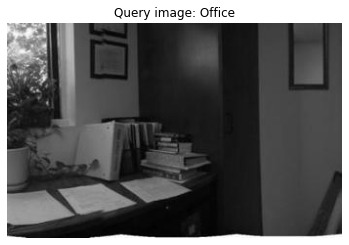

Query: data/scene/test/Office/image_0208.jpg
Top 1 match: data/scene/train/LivingRoom/image_0211.jpg, distance: 1.3067
Top 2 match: data/scene/train/LivingRoom/image_0208.jpg, distance: 1.3067
Top 3 match: data/scene/train/Suburb/image_0151.jpg, distance: 1.3137
Top 4 match: data/scene/train/Office/image_0145.jpg, distance: 1.3146
Top 5 match: data/scene/train/LivingRoom/image_0164.jpg, distance: 1.3184


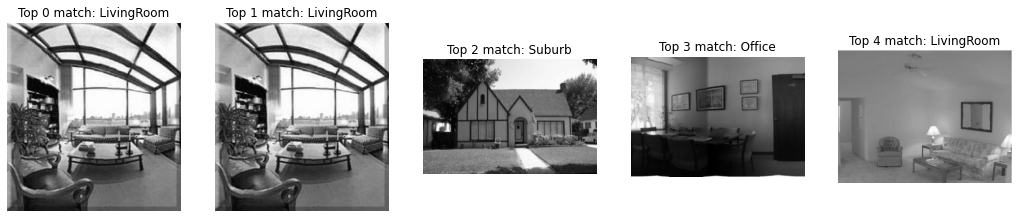

In [ ]:
# test and evaluation
dist_list = []
display_random_numer = random.randint(0,len(ret_file_path_list_vlad)-1)
for eachpic in range(len(train_all_feature_vlad)):
    dist = cal_vec_dist(test_all_feature_vlad[display_random_numer], train_all_feature_vlad[eachpic])
    dist_list.append(dist)
    
# Find the top top_return similar results
dist_array = np.array(dist_list)
top_return = 5
index = np.argsort(dist_array)[:top_return]

plt.imshow(cv2.cvtColor(cv2.imread(ret_file_path_list_vlad[display_random_numer]), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Query image: ' + ret_file_path_list_vlad[display_random_numer].split("/")[3])
plt.show()

print("Query: %s" % (ret_file_path_list_vlad[display_random_numer]))

# Display results
plt.figure(figsize=(18,8))
for i in range(top_return):
    plt.subplot(1,top_return,i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(train_image_file_list[index[i]]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Top ' + str(i) + ' match: ' + train_image_file_list[index[i]].split("/")[3])
    print("Top %d match: %s, distance: %.4f" % (i+1, train_image_file_list[index[i]], dist_array[index[i]]))
plt.show()

## Neural Codes: Step 0, Define functions

- Reference: Artem Babenko, Anton Slesarev, Alexandr Chigorin, Victor Lempitsky, "Neural Codes for Image Retrieval," ECCV 2014, https://arxiv.org/abs/1404.1777

- Process
    - Extract `fc2` layer output as the features
    - Apply cosine similarity (dot product) as the similarity score


In [ ]:
# Define VGG baseline model
# The VGG model file (528 MB) will be downloaded from the Internet when you run this code for the first time.

vgg16_original = vgg.vgg16(pretrained=True)
vgg_model_extract_fc2 = vgg16_original
vgg_model_extract_fc2.classifier = torch.nn.Sequential(*list(vgg16_original.classifier.children())[:-1])
vgg_model_extract_fc2.to(device)

# A toy test the input and output dimension for the modified VGG model
temp_in = torch.rand(1, 3, 224, 224)
temp_in = temp_in.to(device)
print("vgg16_modified, input: ", temp_in.shape) # 1*512*7*7

temp_output = vgg_model_extract_fc2(temp_in)
print("vgg16_modified, fc features: ", temp_output.shape) # 1*4096


vgg16_modified, input:  torch.Size([1, 3, 224, 224])
vgg16_modified, fc features:  torch.Size([1, 4096])


In [ ]:
# Define the feature extraction function
# Note that the images in the dataset are gray scale images, we need to expand them into RGB images to feed into VGG model
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: torch.cat([x, x, x], 0))])

def extract_vgg_fc_feature_from_list(image_file_list):
    all_feature = []
    for idx, eachFile in enumerate(image_file_list):
        if ((idx % 200) ==0 ):
            print("process %d/%d file" % (idx+1, len(image_file_list)))
        img = Image.open(eachFile)
        x = transform(img).unsqueeze(0).to(device)
        fc2_features = vgg_model_extract_fc2(x).cpu().detach().numpy()
        fc2_features = fc2_features/np.linalg.norm(fc2_features) # normalzie features
        all_feature.append(fc2_features)
    return all_feature


## Neural Codes: Step 1, Feature extraction from from both training and test data set

In [ ]:
# Extract features from training images
# train_all_feature_vgg_fc = extract_vgg_fc_feature_from_list(train_image_file_list)
# print("Dimension of Train_all_feature_vgg_fc: (%d, %d)" % (len(train_all_feature_vgg_fc), train_all_feature_vgg_fc[0].shape[1]))
# np.save('data/pt_train_all_feature_vgg_fc.npy', train_all_feature_vgg_fc)

# # Extract features from test images, get all the descriptor vectors of the whole test data set
# number_test_images = 100 # len(test_image_file_list) # use a subset not the full set of 2985 test images
# ret_file_path_list = random.sample(test_image_file_list, number_test_images)

# print('Extract features from test images')
# test_all_feature_vgg_fc = extract_vgg_fc_feature_from_list(ret_file_path_list)
# print("Test_all_feature_vgg_fc: (%d, %d)" % (len(test_all_feature_vgg_fc), test_all_feature_vgg_fc[0].shape[1]))
# np.save('data/pt_test_all_feature_vgg_fc.npy', test_all_feature_vgg_fc)
# np.save('data/pt_ret_file_path_list_vgg_fc.npy', ret_file_path_list)

# It takes some time to extract features, so we can directly load the pre-extracted features.
train_all_feature_vgg_fc = np.load('data/pt_train_all_feature_vgg_fc.npy')
test_all_feature_vgg_fc = np.load('data/pt_test_all_feature_vgg_fc.npy')
ret_file_path_list_vgg_fc = np.load('data/pt_ret_file_path_list_vgg_fc.npy')
print("Dimension of Train_all_feature_vgg_fc: (%d, %d)" % (len(train_all_feature_vgg_fc), train_all_feature_vgg_fc[0].shape[1]))
print("Test_all_feature_vgg_fc: (%d, %d)" % (len(test_all_feature_vgg_fc), test_all_feature_vgg_fc[0].shape[1]))

Dimension of Train_all_feature_vgg_fc: (1500, 4096)
Test_all_feature_vgg_fc: (100, 4096)


## Neural Codes: Step 2, Performance evaluation

In [ ]:
##test and evaluation
avg_precision = []
avg_accuracy = []
top_return = 5
for i in range(len(test_all_feature_vgg_fc)):
    dist_list = []
    if ((i % 200) ==0 ):
        print("process %d/%d file" % (i+1, len(test_all_feature_vgg_fc)))
    for eachpic in range(len(train_all_feature_vgg_fc)):
        dist = cal_vec_dist(test_all_feature_vgg_fc[i], train_all_feature_vgg_fc[eachpic])
        dist_list.append(dist)

    most_sim = np.array(dist_list)

    #choose the three nearest images of the given image 
    index = np.argsort(most_sim)[:top_return]
    input_file_name = ret_file_path_list_vgg_fc[i]
    result_file_name_list = []
    for j in range(len(index)):
        result_file_name_list.append(train_image_file_list[index[j]])
    avg_precision.append(cal_precision(input_file_name, result_file_name_list))
    avg_accuracy.append(cal_accuracy(input_file_name, result_file_name_list))
    
print("Top %d return, mean Precision: %.4f" % (top_return, np.array(avg_precision).mean()))
print("Top %d return, mean Accuracy: %.4f" % (top_return, np.array(avg_accuracy).mean()))


process 1/100 file
Top 5 return, mean Precision: 0.6840
Top 5 return, mean Accuracy: 0.9200


## Neural Codes: Step 3, Visualize the query results

- Randomly choose a query image (see `display_random_numer`) and perform instance search

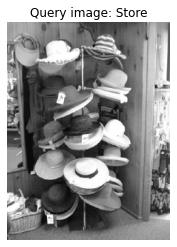

Query: data/scene/test/Store/image_0121.jpg
Top 1 match: data/scene/train/Kitchen/image_0092.jpg, distance: 0.9427
Top 2 match: data/scene/train/Kitchen/image_0144.jpg, distance: 0.9590
Top 3 match: data/scene/train/Office/image_0066.jpg, distance: 0.9590
Top 4 match: data/scene/train/Office/image_0137.jpg, distance: 0.9630
Top 5 match: data/scene/train/Office/image_0161.jpg, distance: 0.9690


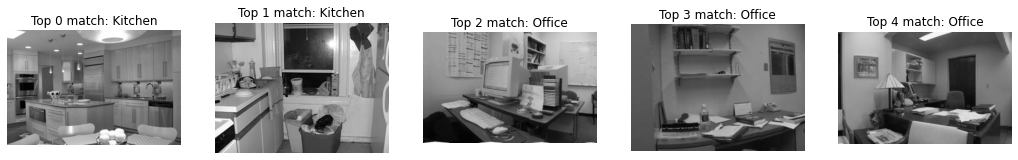

In [ ]:
# test and evaluation
dist_list = []
display_random_numer = random.randint(0, len(ret_file_path_list_vgg_fc)-1)
for eachpic in range(len(train_all_feature_vgg_fc)):
    dist = cal_vec_dist(test_all_feature_vgg_fc[display_random_numer], train_all_feature_vgg_fc[eachpic])
    dist_list.append(dist)
    
# Find the top top_return similar results
dist_array = np.array(dist_list)
top_return = 5
index = np.argsort(dist_array)[:top_return]

plt.imshow(cv2.cvtColor(cv2.imread(ret_file_path_list_vgg_fc[display_random_numer]), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Query image: ' + ret_file_path_list_vgg_fc[display_random_numer].split("/")[3])
plt.show()

print("Query: %s" % (ret_file_path_list_vgg_fc[display_random_numer]))

# Display results
plt.figure(figsize=(18,8))
for i in range(top_return):
    plt.subplot(1,top_return,i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(train_image_file_list[index[i]]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Top ' + str(i) + ' match: ' + train_image_file_list[index[i]].split("/")[3])
    print("Top %d match: %s, distance: %.4f" % (i+1, train_image_file_list[index[i]], dist_array[index[i]]))
plt.show()

## Global pooling: Step 0, Define functions

- Reference:

    - `Global sum-pooling`, Artem Babenko, Victor Lempitsky, "Aggregating Deep Convolutional Features for Image Retrieval," ICCV 2015, https://arxiv.org/abs/1510.07493

    - `Global max-pooling`, Giorgos Tolias, Ronan Sicre, Hervé Jégou, "Particular object retrieval with integral max-pooling of CNN activations," ICLR 2016, https://arxiv.org/abs/1511.05879

    
- Process
    - Extract the last conv layer output, then apply either global sum-pooling or max-pooling to generate features.
    - Apply cosine similarity (dot product) as the similarity score
    

In [ ]:
# Define VGG baseline model
# The VGG model file (528 MB) will be downloaded from the Internet when you run this code for the first time.

vgg16_original = vgg.vgg16(pretrained=True)
vgg_model_extract_conv = vgg16_original
vgg_model_extract_conv.classifier = torch.nn.Sequential(*list(vgg16_original.classifier.children())[:-1])
vgg_model_extract_conv.to(device)

# A toy test the input and output dimension for the modified VGG model
temp_in = torch.rand(1, 3, 224, 224)
temp_in = temp_in.to(device)
print("vgg_model_extract_conv, input: ", temp_in.shape) # 1*3*224*224

temp_output = vgg_model_extract_conv.features[:31](temp_in)
print("vgg_model_extract_conv, 2D conv features: ", temp_output.shape) # 1*512*7*7


vgg_model_extract_conv, input:  torch.Size([1, 3, 224, 224])
vgg_model_extract_conv, 2D conv features:  torch.Size([1, 512, 7, 7])


In [ ]:
# Define feature extraction function
# Note that the images in the dataset are gray scale images, we need to expand them into RGB images to feed into VGG model
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: torch.cat([x, x, x], 0))])

def extract_vgg_conv_feature_from_list(image_file_list, mode='sum'):
    all_feature = []
    for idx, eachFile in enumerate(image_file_list):
        if ((idx % 200) ==0 ):
            print("process %d/%d file" % (idx+1, len(image_file_list)))
            
        img = Image.open(eachFile)
        x = transform(img).unsqueeze(0).to(device)
        conv_features = vgg_model_extract_conv.features[:31](x).cpu().detach().numpy().squeeze(0)
        
        if (mode == 'sum'):
            conv_features = np.sum(conv_features, axis=(1,2))
            conv_features = conv_features/np.linalg.norm(conv_features) # normalzie features
        else:
            print('extract_vgg_conv_feature_from_list: Wrong mode as input')
            break
        all_feature.append(conv_features.reshape(1, -1))
    return all_feature


## Global pooling: Step 1, Feature extraction from from both training and test data set

In [ ]:
# Extract features from training images
# train_all_feature_vgg_conv = extract_vgg_conv_feature_from_list(train_image_file_list, 'sum')
# np.save('data/pt_train_all_feature_vgg_conv.npy', train_all_feature_vgg_conv)
# print("Train_all_feature_vgg_conv: (%d, %d)" % (len(train_all_feature_vgg_conv), train_all_feature_vgg_conv[0].shape[1]))

# # Extract features from test images, get all the descriptor vectors of the whole test data set
# number_test_images = 100 # len(test_image_file_list)
# ret_file_path_list = random.sample(test_image_file_list, number_test_images)

# print('Extract features from test images')
# test_all_feature_vgg_conv = extract_vgg_conv_feature_from_list(ret_file_path_list)
# print("Test_all_feature_vgg_conv: (%d, %d)" % (len(test_all_feature_vgg_conv), test_all_feature_vgg_conv[0].shape[1]))
# np.save('data/pt_test_all_feature_vgg_conv.npy', test_all_feature_vgg_conv)
# np.save('data/pt_ret_file_path_list_vgg_conv.npy', ret_file_path_list)

train_all_feature_vgg_conv = np.load('data/pt_train_all_feature_vgg_conv.npy')
test_all_feature_vgg_conv = np.load('data/pt_test_all_feature_vgg_conv.npy')
ret_file_path_list_vgg_conv = np.load('data/pt_ret_file_path_list_vgg_conv.npy')
print("Train_all_feature_vgg_conv: (%d, %d)" % (len(train_all_feature_vgg_conv), train_all_feature_vgg_conv[0].shape[1]))
print("Test_all_feature_vgg_conv: (%d, %d)" % (len(test_all_feature_vgg_conv), test_all_feature_vgg_conv[0].shape[1]))


Train_all_feature_vgg_conv: (1500, 512)
Test_all_feature_vgg_conv: (100, 512)


## Global pooling: Step 2, Performance evaluation

In [ ]:
##test and evaluation
avg_precision = []
avg_accuracy = []
top_return = 5
for i in range(len(test_all_feature_vgg_conv)):
    dist_list = []
    if ((i % 200) ==0 ):
        print("process %d/%d file" % (i+1, len(test_all_feature_vgg_conv)))
    for eachpic in range(len(train_all_feature_vgg_conv)):
        dist = cal_vec_dist(test_all_feature_vgg_conv[i], train_all_feature_vgg_conv[eachpic])
        dist_list.append(dist)

    most_sim = np.array(dist_list)

    #choose the three nearest images of the given image 
    index = np.argsort(most_sim)[:top_return]
    input_file_name = ret_file_path_list_vgg_conv[i]
    result_file_name_list = []
    for j in range(len(index)):
        result_file_name_list.append(train_image_file_list[index[j]])
    avg_precision.append(cal_precision(input_file_name, result_file_name_list))
    avg_accuracy.append(cal_accuracy(input_file_name, result_file_name_list))
    
print("Top %d return, mean Precision: %.4f" % (top_return, np.array(avg_precision).mean()))
print("Top %d return, mean Accuracy: %.4f" % (top_return, np.array(avg_accuracy).mean()))


process 1/100 file
Top 5 return, mean Precision: 0.6740
Top 5 return, mean Accuracy: 0.9300


## Global pooling: Step 3, Visualize the query results

$\color{red}{\text{Q1. Complete code to perform instance search using global pooling method}}$

Tasks

- Randomly choose a query image (see `display_random_numer`)
- Calculate the distance between the test data `test_all_feature_vgg_conv[display_random_numer]` and all train data feature `train_all_feature_vgg_conv`
- Sort the distance matrix and pick up the top return `top_return`
- Visualize the input image, the top return images and their similarity score.

In [ ]:
# Provide your solution to Q1 here
#
#
#

$\color{red}{\text{Q2. What is the advantage of applying vision-based localization compared with other sensory data (e.g., GPS, IMU)?}}$


In [ ]:
# Provide your solution to Q2 here
# No need programming
#


**Have a nice day!**